In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from tqdm import tqdm

In [2]:
from mtcnn import MTCNN
detector_model = MTCNN()

# **ArcFace**

## *Input*: Imagem BGR 112 x 112

## *Output*: Vetor de 512 dimensões

## *Arquitetura (backbone)*: ResNet101

## *Função Custo*: Additive Angular Margin Loss

### Deng, Jiankang, et al. "ArcFace: Additive Angular Margin Loss for Deep Face Recognition." (2019)

## **Additive Angular Margin Loss**:

<img src="imagens/arcface_train.PNG">

## **Softmax vs. ArcFace**

<img src="imagens/arcface_softmax.PNG">

## **ArcFace vs. outros modelos**

<img src="imagens/arcface_results.PNG">

In [3]:
import insightface
arcface_model = insightface.model_zoo.get_model('arcface_r100_v1')
arcface_model.prepare(ctx_id=-1)

## **Função para a criação do dicionário de paths das imagens do dataset**

In [4]:
def make_dict(dataset_path):

    dic = {}
    os.chdir(dataset_path)
    class_folders = os.listdir('.')

    for class_folder in class_folders:

        os.chdir(class_folder)
        images = os.listdir('.')

        i = 1
        for image in images:
            if not os.path.isfile(class_folder + '{}'.format(i) + '.jpg'):
                os.rename(image, class_folder + '{}'.format(i) + '.jpg')
            i = i + 1

        images = os.listdir('.')
        
        i = 1
        for image in images:
            dic['{}{}'.format(class_folder, i)] = os.path.join(dataset_path, class_folder, image)
            i = i + 1

        os.chdir('..')

    os.chdir('..')

    return dic

In [5]:
dic = make_dict('Turing_Faces')

In [6]:
dic

{'Alex_Koji1': 'Turing_Faces/Alex_Koji/Alex_Koji1.jpg',
 'Ariel_Guerreiro1': 'Turing_Faces/Ariel_Guerreiro/Ariel_Guerreiro1.jpg',
 'Ariel_Guerreiro2': 'Turing_Faces/Ariel_Guerreiro/Ariel_Guerreiro2.jpg',
 'Camila_Fonseca1': 'Turing_Faces/Camila_Fonseca/Camila_Fonseca1.jpg',
 'Camila_Fonseca2': 'Turing_Faces/Camila_Fonseca/Camila_Fonseca2.jpg',
 'Eduardo_Eiras1': 'Turing_Faces/Eduardo_Eiras/Eduardo_Eiras1.jpg',
 'Eduardo_Eiras2': 'Turing_Faces/Eduardo_Eiras/Eduardo_Eiras2.jpg',
 'Eduardo_Eiras3': 'Turing_Faces/Eduardo_Eiras/Eduardo_Eiras3.jpg',
 'Eduardo_Eiras4': 'Turing_Faces/Eduardo_Eiras/Eduardo_Eiras4.jpg',
 'Eduardo_Eiras5': 'Turing_Faces/Eduardo_Eiras/Eduardo_Eiras5.jpg',
 'Enzo_Bustos1': 'Turing_Faces/Enzo_Bustos/Enzo_Bustos1.jpg',
 'Enzo_Bustos2': 'Turing_Faces/Enzo_Bustos/Enzo_Bustos2.jpg',
 'Felipe_Azank1': 'Turing_Faces/Felipe_Azank/Felipe_Azank1.jpg',
 'Felipe_Azank2': 'Turing_Faces/Felipe_Azank/Felipe_Azank2.jpg',
 'Felipe_Azank3': 'Turing_Faces/Felipe_Azank/Felipe_Azank3.j

## **Alinhamento facial realizado pela função da biblioteca do ArcFace**

### Exemplo de imagem retirada do dataset do Turing

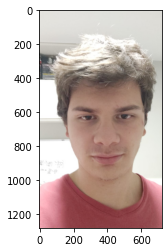

In [7]:
img_path = dic['Ariel_Guerreiro1']
image = cv2.imread(img_path)

plt.imshow(np.flip(image, axis=-1))
plt.show()

### Imagem alinhada a partir da função da biblioteca do ArcFace

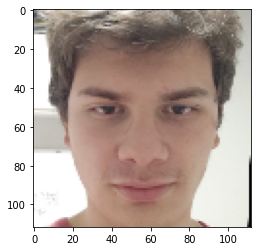

In [8]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB); result = detector_model.detect_faces(image_rgb)
eye_right = np.array(result[0]['keypoints']['right_eye'])
eye_left = np.array(result[0]['keypoints']['left_eye'])
nose = np.array(result[0]['keypoints']['nose'])
mouth_right = np.array(result[0]['keypoints']['mouth_right'])
mouth_left = np.array(result[0]['keypoints']['mouth_left'])
landmarks = np.array([eye_left, eye_right, nose, mouth_left, mouth_right])

aligned_img = insightface.utils.face_align.norm_crop(image, landmarks)

plt.imshow(np.flip(aligned_img, axis=-1))
plt.show()

## **Função para gerar a representação ArcFace de uma imagem**

In [9]:
def get_representation(image, hash_model, landmarks):

    aligned_img = insightface.utils.face_align.norm_crop(image, landmarks)

    img_representation = hash_model.get_embedding(aligned_img)
    img_representation = img_representation.squeeze(axis=0)

    #plt.imshow(aligned_img)
    #plt.show()

    return img_representation

## **Função para gerar o DataFrame de representações**

In [10]:
def make_hash(img_dict, hash_model, detector_model):

    img_list = list(img_dict.values())

    df = pd.DataFrame(columns = ['ArcFace'], index = list(img_dict.keys()))

    representation_list = []
    disable_option = False if len(img_list) > 1 else True
    for img_path in tqdm(img_list, desc='Avaliando Hash...', disable = disable_option):

        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = detector_model.detect_faces(image_rgb)

        # Nenhum rosto detectado
        if len(result) == 0:
            representation_list.append(None)

        else:
            eye_right = np.array(result[0]['keypoints']['right_eye'])
            eye_left = np.array(result[0]['keypoints']['left_eye'])
            nose = np.array(result[0]['keypoints']['nose'])
            mouth_right = np.array(result[0]['keypoints']['mouth_right'])
            mouth_left = np.array(result[0]['keypoints']['mouth_left'])

            landmarks = np.array([eye_left, eye_right, nose, mouth_left, mouth_right])

            representation = get_representation(image, hash_model, landmarks)
            representation_list.append(representation)

    df['ArcFace'] = representation_list

    return df

In [11]:
tic = time.time()
hash_df = make_hash(dic, arcface_model, detector_model)
toc = time.time()

Avaliando Hash...: 100%|██████████| 32/32 [00:48<00:00,  1.53s/it]


In [12]:
print('Tempo de avaliação do hash: {} segundos'.format(toc-tic))

Tempo de avaliação do hash: 48.910807609558105 segundos


In [13]:
hash_df

,ArcFace
Alex_Koji1,"[-0.07898863, 0.29689148, -2.5531418, -1.08932..."
Ariel_Guerreiro1,"[0.32658285, -0.7017476, -0.64553106, -0.57638..."
Ariel_Guerreiro2,"[0.5509473, -0.9909145, -0.34865752, -0.563928..."
Camila_Fonseca1,"[-1.5818309, -1.160022, 1.65914, 0.49970958, 2..."
Camila_Fonseca2,"[-2.0179617, 0.070794165, 2.3806381, -0.884002..."
Eduardo_Eiras1,"[-0.03154268, -1.23299, -0.6005332, 0.20772809..."
Eduardo_Eiras2,"[0.4015549, -1.7482035, -0.32626057, 0.1923889..."
Eduardo_Eiras3,"[0.09118195, -1.7747225, -0.42174166, 1.536756..."
Eduardo_Eiras4,"[-0.63092244, -1.3873752, -0.76119167, -0.2832..."
Eduardo_Eiras5,"[-0.090289675, -1.9531868, -0.14185497, 0.9069..."


In [14]:
hash_df.to_pickle('arcface_files/hash_df.pkl', protocol=4)

import pandas as pd
hash_df = pd.read_pickle('arcface_files/hash_df.pkl')

## **Função para determinar a similaridade cossenoidal entre dois vetores**

In [15]:
def find_cosine_similarity(source_representation, test_representation):

    a = np.dot(source_representation, test_representation)
    b = np.linalg.norm(source_representation)
    c = np.linalg.norm(test_representation)

    return 1 - a/(b*c)

## **Função para gerar o DataFrame de similaridades cossenoidais**

In [16]:
def make_metrics_dataframe(hash_df, one_compair=False):

    hash_index = list(hash_df.index)

    column_names = ['CosineSimilarity']
    index_names = []
    aux = hash_index.copy()
    for i in hash_index:
        aux.pop(0)
        for j in aux:
            index_names.append(i + ' - ' + j)

    metrics_df = pd.DataFrame(columns=column_names, index=index_names)

    if one_compair:
  
        first_index = hash_index[0]
        for index in tqdm(hash_index[1:], desc = 'Avaliando a primeira pessoa em relação a todas as outras...'):

            cosine_distance = find_cosine_similarity(hash_df.at[first_index, 'ArcFace'], hash_df.at[index, 'ArcFace'])

            string = first_index + ' - ' + index
            metrics_df.at[string, 'CosineSimilarity'] = cosine_distance

    else:

        people_pbar = tqdm(range(len(hash_index)), desc = 'Avaliando cada pessoa em relação a todas as outras...')
        for i in people_pbar:
			
            index = hash_index[i]
            for j in range(i+1, len(hash_index)):

                jndex = hash_index[j]
                cosine_distance = find_cosine_similarity(hash_df.at[index, 'ArcFace'], hash_df.at[jndex, 'ArcFace'])

                string = index + ' - ' + jndex
                metrics_df.loc[string] = cosine_distance

    metrics_df.dropna(inplace = True)

    return metrics_df

In [17]:
metrics_df = make_metrics_dataframe(hash_df, one_compair=False)

Avaliando cada pessoa em relação a todas as outras...: 100%|██████████| 32/32 [00:00<00:00, 224.19it/s]


In [18]:
metrics_df

,CosineSimilarity
Alex_Koji1 - Ariel_Guerreiro1,1.037276
Alex_Koji1 - Ariel_Guerreiro2,0.889063
Alex_Koji1 - Camila_Fonseca1,1.013353
Alex_Koji1 - Camila_Fonseca2,0.942209
Alex_Koji1 - Eduardo_Eiras1,0.994663
...,...
Paulo_Sestini2 - Rodrigo_Fill2,0.862796
Paulo_Sestini2 - Victor_Jinsi1,0.927915
Rodrigo_Fill1 - Rodrigo_Fill2,0.214137
Rodrigo_Fill1 - Victor_Jinsi1,1.007906


In [19]:
metrics_df.to_pickle('arcface_files/metrics_df.pkl', protocol=4)

import pandas as pd
metrics = pd.read_pickle('arcface_files/metrics_df.pkl')

## **Função para gerar o DataFrame de predições do modelo e resultados esperados**

In [20]:
def make_verification_dataframe(metrics_df, threshold=.65):

    columns_names = ['Verified', 'GroundTruth']
    verification_df = pd.DataFrame(columns = columns_names, index = metrics_df.index)

    comp_pbar = tqdm(range(len(metrics_df.index)), desc = 'Realizando a verificação para cada par de indivíduos...')
    for i in comp_pbar:

        index = metrics_df.index[i]
        value  = metrics_df.iat[i, 0]

        verified = value < threshold
        if verified: identified = True
        else: identified = False

        names = index.split(' - ')
        if (names[0])[:-1] == (names[1])[:-1]: ground_truth = True
        else: ground_truth = False

        ensembles = [identified, ground_truth]
        verification_df.loc[index] = ensembles

    return verification_df

In [21]:
verification_df = make_verification_dataframe(metrics_df)

Realizando a verificação para cada par de indivíduos...: 100%|██████████| 496/496 [00:00<00:00, 4696.12it/s]


In [22]:
verification_df

,Verified,GroundTruth
Alex_Koji1 - Ariel_Guerreiro1,False,False
Alex_Koji1 - Ariel_Guerreiro2,False,False
Alex_Koji1 - Camila_Fonseca1,False,False
Alex_Koji1 - Camila_Fonseca2,False,False
Alex_Koji1 - Eduardo_Eiras1,False,False
...,...,...
Paulo_Sestini2 - Rodrigo_Fill2,False,False
Paulo_Sestini2 - Victor_Jinsi1,False,False
Rodrigo_Fill1 - Rodrigo_Fill2,True,True
Rodrigo_Fill1 - Victor_Jinsi1,False,False


In [23]:
verification_df.to_pickle('arcface_files/verification_df.pkl', protocol=4)

import pandas as pd

verification = pd.read_pickle('arcface_files/verification_df.pkl')

## **Função para avaliar o desempenho do modelo**

In [24]:
def make_f1_dataframe(verif_df):

    TP, FP, TN, FN = 0, 0, 0, 0   
    column_names = ['Accuracy', 'Recall', 'Precision', 'Positive Pairs Rate', 'Negative Pairs Rate', 'F1']
    for i in range(len(verif_df.index)):

        if (verif_df.iat[i, 0] == verif_df.iat[i, 1]) and (verif_df.iat[i, 0] == True):
            TP += 1
        elif (verif_df.iat[i, 0] != verif_df.iat[i, 1]) and (verif_df.iat[i, 0] == True):
            FP += 1 
        elif (verif_df.iat[i, 0] == verif_df.iat[i, 1]) and (verif_df.iat[i, 0] != True):
            TN += 1
        else:
            FN += 1

    accuracy = (TP+TN)/(TP+TN+FP+FN)
    recall = TN/(TN+FN)
    precision = TP/(TP+FP)
    positive_rate = TP/(TP+FN)
    negative_rate = TN/(TN+FP)
    f1 = 2*(recall*precision)/(recall+precision)
    f1_df = pd.DataFrame([list([accuracy, recall, precision, positive_rate, negative_rate, f1])], columns = column_names, index = ['Results:'])

    return f1_df

In [25]:
make_f1_dataframe(verification_df)

,Accuracy,Recall,Precision,Positive Pairs Rate,Negative Pairs Rate,F1
Results:,1.0,1.0,1.0,1.0,1.0,1.0


## **Distribuição das similaridades para pares positivos e negativos**

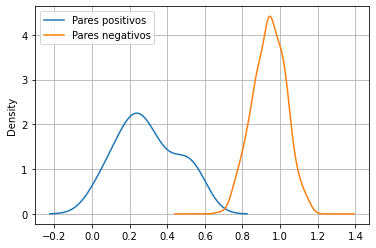

In [26]:
(metrics_df[verification_df['GroundTruth'] == True])['CosineSimilarity'].plot.kde()
(metrics_df[verification_df['GroundTruth'] == False])['CosineSimilarity'].plot.kde()
plt.legend(['Pares positivos', 'Pares negativos'])
plt.grid()
plt.show()